In [333]:
import pandas as pd
import numpy as np
import os
import sys
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from datetime import datetime
# Make `src` dir can be imported
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))  # /aicup-predict-energy-generation
sys.path.append(project_root_path)  

from src.fe_tools import create_time_features
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

In [337]:
df_raw = pd.read_csv('../data/processed_data/combined_data.csv')
df_raw = create_time_features(df_raw, "datetime")
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_sunlight = pd.read_csv('../data/processed_data/sunlight_simulation_data.csv')
df_sunlight = create_time_features(df_sunlight, "datetime")
df_sunlight['date'] = pd.to_datetime(df_sunlight['date'])
# df_sunlight.set_index('datetime', inplace=True)

In [348]:
df_device = df_raw[(df_raw['device'] == 'L10')]
df_device[df_device['date'] == pd.Timestamp(2024, 7, 16)]

,locationcode,datetime,windspeed,pressure,temperature,humidity,sunlight,power,device,date,year,month,day,hour,min,day_of_week,week_of_year,quarter
87544,10,2024-07-16 05:04:14,2.26,1008.23,27.06,83.14,22.50,0.0,L10,2024-07-16,2024,7,16,5,4,1,29,3
87545,10,2024-07-16 05:05:14,0.87,1008.22,27.05,82.84,27.50,0.0,L10,2024-07-16,2024,7,16,5,5,1,29,3
87546,10,2024-07-16 05:06:14,1.31,1008.23,27.04,82.77,34.17,0.0,L10,2024-07-16,2024,7,16,5,6,1,29,3
87547,10,2024-07-16 05:07:14,1.22,1008.22,27.01,83.00,41.67,0.0,L10,2024-07-16,2024,7,16,5,7,1,29,3
87548,10,2024-07-16 05:08:14,0.78,1008.24,26.99,82.94,50.83,0.0,L10,2024-07-16,2024,7,16,5,8,1,29,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88368,10,2024-07-16 18:48:16,1.05,1007.84,31.03,73.20,51.67,0.0,L10,2024-07-16,2024,7,16,18,48,1,29,3
88369,10,2024-07-16 18:49:16,0.78,1007.89,31.03,73.17,44.17,0.0,L10,2024-07-16,2024,7,16,18,49,1,29,3
88370,10,2024-07-16 18:50:16,0.17,1007.90,31.05,73.22,36.67,0.0,L10,2024-07-16,2024,7,16,18,50,1,29,3
88371,10,2024-07-16 18:51:16,0.00,1007.91,31.07,73.09,30.00,0.0,L10,2024-07-16,2024,7,16,18,51,1,29,3


In [349]:
df_test = df_sunlight[(df_sunlight['date'] == pd.Timestamp(2024, 7, 16))]

# df_test.to_csv('../data/test_data/df_L10_20240705.csv', index=False)

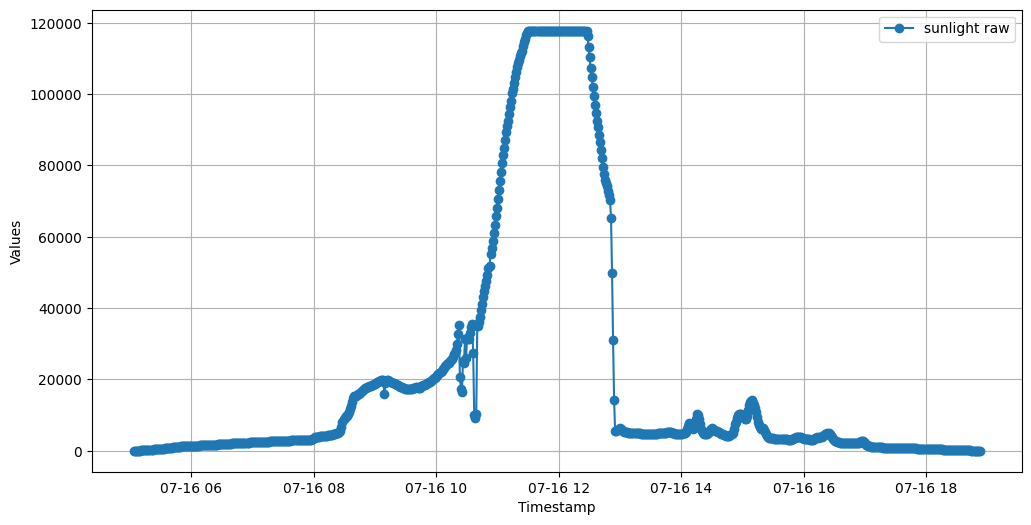

In [352]:
plt.figure(figsize=(12, 6))
plt.plot(df_test['datetime'] ,df_test.sunlight, label='sunlight raw', marker='o')
# plt.title('FirstTS and SecondTS Time Series')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

In [353]:
def replace_saturated_sunlight(df, window_lenght, polyorder, saturation_value=117758.2):
    smoothed_data = df.copy()

    smoothed_data['sunlight'] = savgol_filter(
        smoothed_data['sunlight'].where(smoothed_data['sunlight'] < saturation_value, np.nan).fillna(saturation_value),
        window_length=window_lenght,
        polyorder=polyorder
    )

    df_sim_sunlight = smoothed_data[['sunlight']].rename(columns={'sunlight':'sim_sunlight'})
    df_merge = pd.merge(df, df_sim_sunlight, how='inner', on=df_test.index)
    df_merge['sunlight'] = np.where((df_merge['sunlight'] == saturation_value) & (df_merge['sim_sunlight'] > df_merge['sunlight']), 
                                    df_merge['sim_sunlight'], df_merge['sunlight'])
    df_merge = df_merge.drop(['sim_sunlight'], axis=1)
    # df_merge = df_merge.set_index('key_0')
    return df_merge

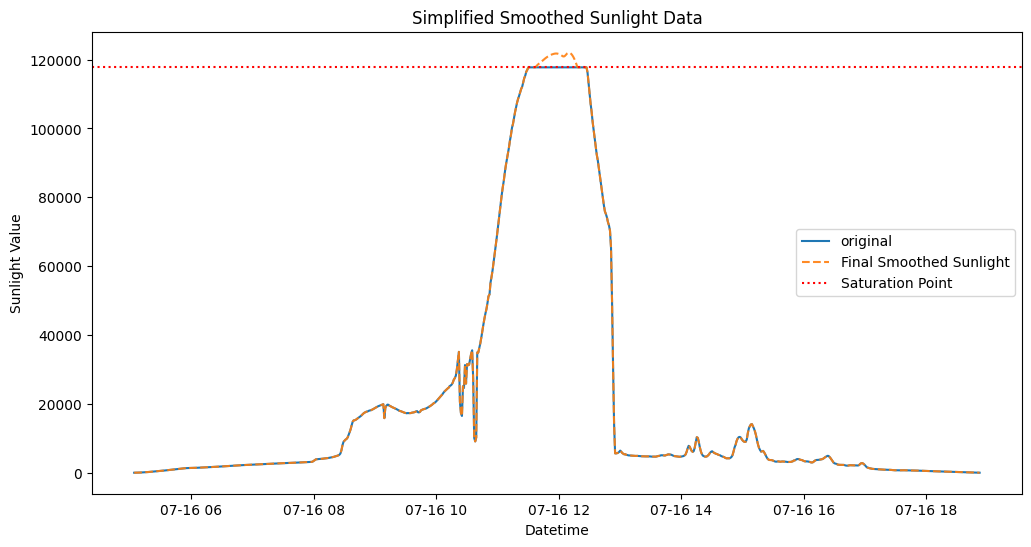

In [370]:
saturation_value = 117758.2
df_result = replace_saturated_sunlight(df_test, window_lenght=95, polyorder=2)

# Plot the smoothed sunlight data
plt.figure(figsize=(12, 6))
plt.plot(df_test['datetime'], df_test['sunlight'], label='original')
plt.plot(df_result['datetime'], df_result['sunlight'], label='Final Smoothed Sunlight', linestyle='--', alpha=0.9)
plt.axhline(y=saturation_value, color='red', linestyle=':', label='Saturation Point')
plt.title('Simplified Smoothed Sunlight Data')
plt.xlabel('Datetime')
plt.ylabel('Sunlight Value')
plt.legend()
plt.show()